# SYNTHETIC DATASET PARAMETER ESTIMATION FOR THE CARMENES PG SUBSAMPLE OBJECTS

**IMPORTANT NOTE:** This notebook is almost the same as a previous one ("SyntheticDataset_07_Parameter_estimation_All_CARMENES_GTO"), but applied to the RV curves in the PG subsample from CARMENES sample (i.e. objects from the CARM\_VIS sample of NZP-corrected RV curves which also have TESS light curves available for PG calculation).

**Note:** Minor changes applied over the original "obs_SD_07_Parameter_estimation_All_CARMENES_GTO.ipynb":
- Some `nan` and other incorrect values were detected is some of the variables, so it was necessary to drop them before fitting the distributions.

Each noiseless, synthetic sample will be generated by means of a sinusoidal function, in the form:

$$x(t)=A\cos\{2\pi(\nu(t-\tau)+\delta)\}+c$$

With:
- $A:\:amplitude\:of\:the\:signal$
- $\nu:\:frequency\:of\:the\:signal$
- $\tau:\:reference\:epoch$
- $\delta:\:phase\:of\:the\:signal$
- $c:\: offset$

Initially, we will need these typical basic parameters to generate the basic, noiseless sinusoidal curves that simulate the pulsation of the stars.
- Amplitude: given by theoretical calculations, with the amplitude detection limit predicted by other studies.
- Frequency: given by theoretical calculations, with the predicted range for M-dwarf stars.
- Reference epoch: will be taken randomly (uniform distribution) from the full time span of the real datasets.
- Phase: random value (uniform distribution), $\delta\in[0, 1)$.
- Offset: as we are trying to simulate NZP-corrected RV time series, it will be set invariably to 0.

**IMPORTANT NOTE: SHOULD AMPLITUDES AND FREQUENCIES BE SOMEHOW RELATED FOR THE TESS AND CARMENES SAMPLES THAT WILL BE CREATED FROM THE BASIC, NOISELESS SAMPLE? (i.e. GREATER AMPLITUDES SHOULD HAVE LONGER PERIODS)**

Additionally, the ideal curves will be generated under two important conditions: first, their sampling frequency must be high enough for periodograms to be able to extract the frequency of the sinusoid; second, the number of points in the time series must be high enough to cover a number of the expected complete periods. The underlaying idea is that the periodogram is able to extract the information from the perfect time series (S1 sample) without trouble, so that this initial S1 sample serves as a benchmark for later, noisy and imperfectly sampled time series (S2, S3 and S4 samples).

We need to extract the statistical distributions of the parameters for the real curves (the PG subsample of 269 CARMENES RV curves - CARM_VIS NZP-corrected RV time series) in order to later apply some parameters to the creation of the ideal synthetic dataset (S1 sample). The parameters of the real time series to be explored include:
- Offset (mean value) of the time series. Its distribution should define the random offset ($c$ value) for the noiseless samples. However, in the particular case of NZP-corrected time series, we just set it to 0.
- Data point noise values of the time series curves: this will define a pool of noise distributions to generate data point noise values to generate the noisy synthetic time series.
- Sampling pattern: this will define a pool of sampling patterns of random choice in order to generate the imperfectly sampled synthetic time series.
- Overall period of time (for all the real dataset): this will define the range of reference epoch values allowed for the synthetic time series.

Remember that these statistical distributions and pattern distributions will be calculated for the so called PG subsample, i.e. the 269 RV time series with $RMS\lt5\;\rm{m s}^{-1}$.


## Modules and configuration

### Modules

In [1]:
import pandas as pd
import numpy as np

import lightkurve as lk

from scipy.stats import normaltest, ttest_ind, pearsonr

import numbers

from distfit import distfit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [2]:
# CONFIGURATION:
GTO_FILE = "../data/SELECTION_for_PG_CARM_VIS_objects_with_PG.csv" # The file containing the 269 stars for PG analysis.
GTO_OBJECTS_TO_DROP = []

IMAGE_FOLDER = "./img/"

DIST_FILES_FOLDER = "../data/DIST_FILES/"
DIST_SUMMARY_FILE = "../data/DIST_FILES/Parameter_distributions_PG_subsample.csv" # A new file.

RANDOM_STATE = 11 # For reproducibility

# STATISTICAL CONSTANTS:
SIGMAS = 3.0 # Number of sigmas above which to discard outliers.
LOW_PC = 1.0 # Lower percentile (%) to discard possible outliers by percentile method.
HIGH_PC = 99.0 # Higher percentile (%) to discard possible outliers by percentile method.
ALPHA = 1e-3 # Significance threshold for statistical tests

### Functions

In [3]:
def discard_outliers_sigma(x, n_sigmas):
    '''Discard outliers from a list using n_sigma-based approach'''
    x_mean = np.nanmean(x)
    x_std = np.nanstd(x)
    x_low = x_mean - n_sigmas * x_std
    x_high = x_mean + n_sigmas * x_std
    filtered_x = [i for i in x if i >= x_low and i <= x_high]
    return filtered_x

In [4]:
def discard_outliers_pc(x, low_pc, high_pc):
    '''Discard outliers from a list using a percentile-based approach'''
    x_low = np.nanpercentile(x, low_pc)
    x_high = np.nanpercentile(x, high_pc)
    filtered_x = [i for i in x if i >= x_low and i <= x_high]
    return filtered_x

In [5]:
def draw_hist(d1, d1_label, fig_filename=None):
    '''Draws an histogram of the values passed. It also calulates the statistics
    and tests the goodness of fit by a Gaussian distribution'''
    # Plots and saves the figure
    kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    plt.title(d1_label + " values distribution", fontsize=16)
    plt.grid(axis='both', alpha=0.75)
    plt.xlabel(d1_label, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    sns.distplot(d1, label=d1_label, **kwargs)
    #sns.histplot(d1, label=d1_label)
    #plt.xlim(0,100)
    #plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Display basic statistics:
    print(pd.Series(d1).describe())
    # Perform the normaltest (D'Agostino and Pearson) for Gaussian distribution fit:
    k2, p = normaltest(d1)
    alpha = ALPHA
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("***This distribution does NOT come from a Gaussian distribution" \
              "(with significance level = %.6f)" %(1.0 - alpha))
    else:
        print("This distribution MIGHT COME come from Gaussian distribution" \
              "(with significance level = %.6f)" %(1.0 - alpha))

In [6]:
def compare_dist(d1, d2, d1_label, d2_label, varname=None, fig_title=None, fig_filename=None):
    '''Plots and saves overlapped histograms.
    It also shows the result of a t-Student test.'''
    # Plots and saves the figure
    kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    if fig_title is None:
        plt.title("Comparison of distributions", fontsize=16)
    else:
        plt.title(fig_title, fontsize=16)
    plt.grid(axis='x', alpha=0.75)
    if varname is None:
        plt.xlabel("%s / %s" %(d1_label, d2_label), fontsize=12)
    else:
        plt.xlabel(varname, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    sns.distplot(d1, label=d1_label, **kwargs)
    sns.distplot(d2, label=d2_label, **kwargs)
    #plt.xlim(0,100)
    plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Perform the t-Student test (as independent samples):
    stat, p = ttest_ind(d1, d2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('***Probably different distributions')

In [7]:
def scatter_graph(data, var_x, var_y, fig_filename=None):
    '''Plots a scatter plot of two columns of a dataframe.
    It also calculates and shows Pearson's correlation coefficient.'''
    #rv_x_var = var_x
    #tess_y_var = var_y
    #kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    plt.title(var_y + " vs " + var_x, fontsize=16)
    plt.grid(axis='both', alpha=0.75)
    plt.xlabel(var_x, fontsize=12)
    plt.ylabel(var_y, fontsize=12)
    sns.scatterplot(data=data, x=var_x, y=var_y)
#    plt.xlim(0.0, 1.0)
#    plt.ylim(0.0, 1.0)    
    plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Calculate the Pearson correlation coefficient between the two results:
    corr, _ = pearsonr(data[var_x], data[var_y])
    print('Pearson\'s correlation value: %.3f' % corr)

## Load the CARM_VIS (PG subsample) objects information

It will be needed to calculate stats for the synthetic dataset parameters.

In [8]:
gto = pd.read_csv(GTO_FILE, sep=',', decimal='.')
gto.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,WF_offset_PG_TESS,WF_e_offset_PG_TESS,WF_FAP_PG_TESS,WF_valid_PG_TESS,WF_error_PG_TESS,WF_elapsed_time_PG_TESS,WF_plain_file_TESS,WF_fig_file_TESS,PG_file_RV,PG_file_TESS
0,J23548+385,RX J2354.8+3831,-,NaN,358.713658,38.526340,23:54:51.46,+38:31:36.2,110.941908,-23.024449,...,999.999756,2.151008e-06,1.0,1.0,NaN,94.758838,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23548+38...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23548+385_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23548+385_RV_PG.dat
1,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,-67.303426,...,1000.000122,9.022946e-07,1.0,1.0,NaN,132.607176,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23505-09...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23505-095_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23505-095_RV_PG.dat
2,J23431+365,GJ 1289,-,1289,355.781509,36.536310,23:43:06.31,+36:32:13.1,107.922839,-24.336479,...,999.999512,4.306074e-06,1.0,1.0,NaN,97.939914,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23431+36...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23431+365_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23431+365_RV_PG.dat
3,J23381-162,G 273-093,-,4352,354.532687,-16.236514,23:38:08.16,-16:14:10.2,61.845437,-69.825220,...,1000.000122,9.022946e-07,1.0,1.0,NaN,136.603404,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23381-16...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23381-162_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23381-162_RV_PG.dat
4,J23245+578,BD+57 2735,-,895,351.126628,57.853057,23:24:30.51,+57:51:15.5,111.552287,-3.085183,...,999.999512,3.720858e-06,1.0,1.0,NaN,131.327304,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23245+57...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23245+578_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23245+578_RV_PG.dat


In [9]:
gto.shape

(269, 300)

We have here all the 269 objects of the PG subsample.

In [10]:
print(list(gto.columns))

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

### Clean the object list

To be on the safe side, we remove the objects that gave trouble during the RV periodogram calculations:

In [11]:
gto.loc[gto['valid_PG_RV'] == 0, 'Karmn']

Series([], Name: Karmn, dtype: object)

Ok, it's confirmed that no problematic record is found.

In [12]:
gto = gto[gto['valid_PG_RV'] == 1].reset_index(drop=True).copy()
gto.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,WF_offset_PG_TESS,WF_e_offset_PG_TESS,WF_FAP_PG_TESS,WF_valid_PG_TESS,WF_error_PG_TESS,WF_elapsed_time_PG_TESS,WF_plain_file_TESS,WF_fig_file_TESS,PG_file_RV,PG_file_TESS
0,J23548+385,RX J2354.8+3831,-,NaN,358.713658,38.526340,23:54:51.46,+38:31:36.2,110.941908,-23.024449,...,999.999756,2.151008e-06,1.0,1.0,NaN,94.758838,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23548+38...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23548+385_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23548+385_RV_PG.dat
1,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,-67.303426,...,1000.000122,9.022946e-07,1.0,1.0,NaN,132.607176,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23505-09...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23505-095_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23505-095_RV_PG.dat
2,J23431+365,GJ 1289,-,1289,355.781509,36.536310,23:43:06.31,+36:32:13.1,107.922839,-24.336479,...,999.999512,4.306074e-06,1.0,1.0,NaN,97.939914,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23431+36...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23431+365_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23431+365_RV_PG.dat
3,J23381-162,G 273-093,-,4352,354.532687,-16.236514,23:38:08.16,-16:14:10.2,61.845437,-69.825220,...,1000.000122,9.022946e-07,1.0,1.0,NaN,136.603404,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23381-16...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23381-162_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23381-162_RV_PG.dat
4,J23245+578,BD+57 2735,-,895,351.126628,57.853057,23:24:30.51,+57:51:15.5,111.552287,-3.085183,...,999.999512,3.720858e-06,1.0,1.0,NaN,131.327304,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23245+57...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23245+578_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23245+578_RV_PG.dat


In [13]:
gto.shape

(269, 300)

269 objects remain, no object was removed.

## Synthetic dataset parameter definition

We first initialize the result DataFrame to store the information on all the distributions

In [14]:
fit_dist = pd.DataFrame(columns=['Group', 'Variable', 'Distribution', 'Dist_file'])
fit_dist

,Group,Variable,Distribution,Dist_file


In [15]:
fit_dist.dtypes

Group           object
Variable        object
Distribution    object
Dist_file       object
dtype: object

In [16]:
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

### Common to all RV curves

**Note:** we have decided to keep the basic parameters of sampling and time of observation equal for all synthetic samples, no matter which their oscillation frequencies are. For this reason, different records will contain different numbers of complete periods of the signal.

#### Minimum sampling frequency for benchmark dataset

The sampling frequency must be compliant with the basic Nyquist criterion:

$$f_{sampling}\gt2f_{max}$$

The maximum frequency ($f_{max}$) corresponds to the inverse of the minimum period we are looking for. Recall that the pulsation periods we were looking for were in the range $P\in[0.006944, 0.208333]\;\rm{d}$ or, equivalently, frequencies in the range $f\in[144.0, 4.8]\;\rm{d}^{-1}$. To be even more on the safe side, we will instead take the $f_{max}$ value from the frequency range we defined for periodograms, i.e. $f\in[288.0, 2.8]\;\rm{d}^{-1}$. Hence, $f_{max}=288.0\;\rm{d}^{-1}$, and the sampling of the benchmark dataset must be:

$$f_{sampling}\gt2\times288\;d^{-1}=576\;d^{-1}$$

Or, equivalently, the samples must be spaced apart no greater than:

$$\Delta t\lt\frac{1}{f_{sampling}}=\frac{1}{576}\approx0.0017\:d$$


#### Minimum time of observation for benchmark dataset

For the length of the benchmark time series we will choose a value that covers 10 complete periods of the signal with the lowest possible frequency - i.e. maximum period length - we searched for in periodograms, which was $P_{max}=10\;\rm{h}$, or $f_{}=2.4\;\rm{d}^{-1}$. Hence:

$$T_{obs}\gt10\times\frac{1}{f_{min}}=10\times\frac{1}{2.4}\approx4.1667\;\rm{d}$$

**CONCLUSION:** compliant with both conditionts, we choose a separation between samples of $0.0016\:d$ and an _observation time_ of $4.2\:d$, to keep the figures simplicity and to have just $2626$ points on each time series:

$$\Delta t=0.0016\:d$$

$$T_{obs}=4.2\:d$$

$$N=2626$$


Hence, we can record our two first distributions in our summary.

In [17]:
group = "BENCHMARK"
variable = "Ps"
d_model = dict({'fixed_value': 0.0016}) # Special mode meaning "fixed value" (no distribution file is saved)
dist_to_save = None
filename = None
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

In [18]:
group = "BENCHMARK"
variable = "Tobs"
d_model = dict({'fixed_value': 4.2}) # Special mode meaning "fixed value" (no distribution file is saved)
dist_to_save = None
filename = None
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

In [19]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},None
1,BENCHMARK,Tobs,{'fixed_value': 4.2},None


#### Frequency range of pure sinusoidal signals (theoretical)

This is just the range of the expected frequencies to find in the $He^{3}$-burning instability band. The periods range from $20\;\min$ to $3\;h$ (i.e. $0.013888-0.125\;d$), so the frequencies will have a range of:

$$f\in[8.0, 72.0]\;d^{-1}$$

Without any further information, we will be assuming a _**uniform distribution**_ for the frequencies to be generated. We generate and save it.

**IMPORTANT NOTE:** according to the percentage of PG subsample objects in the $He^{3}-burning$ instability band ($\approx74\%$), we will establish a prior fraction of $26\%$ of start that will not pulsate at all.

In [20]:
group = "BENCHMARK"
variable = "frequency"
dist_to_save = distfit(distr='uniform')
dist_to_save.fit_transform(pd.Series([8.0, 72.0]))
d_model = dist_to_save.model
filename = group + "_" + variable +"_PG_subsample_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[distfit] >fit..
[distfit] >transform..
[distfit] >[uniform] [0.00 sec] [RSS: 0.2929687] [loc=8.000 scale=64.000]
[distfit] >Compute confidence interval [parametric]
[pypickle] Pickle file saved: [../data/DIST_FILES/BENCHMARK_frequency_PG_subsample_dist.pickle]
[distfit] >Saving.. True


In [21]:
# TEST EXAMPLE:
dist_to_save.generate(n=20)

[distfit] >Generate 20 uniform distributed samples with fitted params (8.0, 64.0).


array([54.4736819 , 46.36515935, 39.99594113, 44.78755664, 14.01957864,
       11.72094735, 60.07107223, 41.78215005, 27.96310347, 36.52795964,
       67.63254254, 70.06565317, 42.78170549, 54.34334708, 30.35848401,
       59.44794029, 20.53981892, 59.01382486, 13.07159666, 24.03905564])

In [22]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},None
1,BENCHMARK,Tobs,{'fixed_value': 4.2},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_PG_subsample_dist.pickle


#### Phase range for pure sinusoidals

This will be just a simple, _**uniform distribution**_ between 0 and 1.

$$\delta\in[0.0, 1.0)$$


In [23]:
group = "BENCHMARK"
variable = "phase"
dist_to_save = distfit(distr='uniform')
dist_to_save.fit_transform(pd.Series([0.0, 1.0]))
d_model = dist_to_save.model
filename = group + "_" + variable +"_PG_subsample_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[distfit] >fit..
[distfit] >transform..
[distfit] >[uniform] [0.0 sec] [RSS: 1200.0000000] [loc=0.000 scale=1.000]
[distfit] >Compute confidence interval [parametric]
[pypickle] Pickle file saved: [../data/DIST_FILES/BENCHMARK_phase_PG_subsample_dist.pickle]
[distfit] >Saving.. True


In [24]:
# TEST EXAMPLE:
dist_to_save.generate(n=20)

[distfit] >Generate 20 uniform distributed samples with fitted params (0.0, 1.0).


array([0.27882349, 0.22503321, 0.48522828, 0.89389061, 0.65967084,
       0.23461401, 0.36403298, 0.5643236 , 0.01341906, 0.02725458,
       0.07370352, 0.53122904, 0.80417231, 0.29867789, 0.3005221 ,
       0.90956737, 0.19821927, 0.67484139, 0.77454027, 0.02057451])

In [25]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},None
1,BENCHMARK,Tobs,{'fixed_value': 4.2},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_PG_subsample_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_PG_subsample_dist.pickle


### PG subsample curves stats

**NOTE:** although the approach for random noise will be now a different one, we keep the distribution for all noise values present in the full sample, fitted to a single distribution with all the individual noise values in all the data points from all the time series. We just change the name of the variable, in order for it to be much clearer.

In [26]:
# Initialize lists:
rv_offsets = []
rv_epochs = []
rv_errors = []
# Add all relevant values
#for i in range(0, 5):
for i in range(0, len(gto)):
    # Update offset list:
    #rv_offsets.append(gto.loc[i, 'wmean_RV'])
    rv_offsets.append(0) # Offset should be 0 for NZP-corrected curves.
    # Read the original RV time series of the object.
    rv_ts = pd.read_csv(gto.loc[i, 'rv_file'], sep=' ', decimal='.', names=['time', 'rv', 'rv_error'])
    # Update epoch list (incorporate the minimum value - i.e. starting observation time - of each file):
    rv_epochs.append(rv_ts['time'].min())
    # Update error values list (this needs to incorporate all the values present on each file):
    rv_errors.extend(rv_ts['rv_error'].tolist())

In [27]:
print("Offsets list length: %d" %len(rv_offsets))
print("Reference epochs list length: %d" %len(rv_epochs))
print("Noise values list length: %d" %len(rv_errors))

Offsets list length: 269
Reference epochs list length: 269
Noise values list length: 13463


In [28]:
# Remove anything that is not a correct number from all the lists:
rv_offsets = [elem for elem in rv_offsets if isinstance(elem, numbers.Number)]
rv_epochs = [elem for elem in rv_epochs  if isinstance(elem, numbers.Number)]
rv_errors = [elem for elem in rv_errors  if isinstance(elem, numbers.Number)]
# [x for x in list_1 if isinstance(x, numbers.Number)]

In [29]:
print("Offsets list length (after cleaning): %d" %len(rv_offsets))
print("Reference epochs list length (after cleaning): %d" %len(rv_epochs))
print("Noise values list length (after cleaning): %d" %len(rv_errors))

Offsets list length (after cleaning): 269
Reference epochs list length (after cleaning): 269
Noise values list length (after cleaning): 13463


It is logical that no element was dropped, because the NZP-corrected time series have already been, by definition, cleaned of incorrect values.

#### Amplitude range for radial velocity curves (theoretical)

This just come from the thesis' directors experience, as:

$$A_{RV}\:\in\:[0.1, 1.5]\:ms^{-1}$$

**IMPORTANT NOTE / QUESTION:** in spite of the thesis' directors suggestion of putting an upper limit to the oscilations of $1.5\:ms^{-1}$ (basically, because no amplitudes greater than that have been detected with predious methods), **shouldn't we remove such upper limit and let _Machine Learning_ do its detection job?**. That is, raise the bar a little bit more for the synthetic dataset creation (amplitudes up to $2.5\:ms^{-1}$ maybe?). The reason for this is the following: this being an _ML_ approach, maybe it is better to generate a more ample dataset without previous assumptions about what is detectable and what is not detectable. This larger dataset can be easily filtered in the future to choose only the amplitudes below that $1.5\:ms^{-1}$ (as we are going to store the value of the amplitude for each sample). When filtering, it must be remembered that the number of non-pulsating stars must be reduced accordingly, to keep the agreed upon ratio of $13%$ of non-pulsating stars.

Unless other more appropriate distribution is found, an uniform distribution  will be considered between these two values.

Notice also that previously, some specific percentage ($26\%$) of synthetic RV curves will be earmarked as "non-pulsating", i.e. just constant values (same as _offset_ value).

In [30]:
group = "BENCHMARK"
variable = "amplitudeRV"
dist_to_save = distfit(distr='uniform')
dist_to_save.fit_transform(pd.Series([0.1, 1.5]))
d_model = dist_to_save.model
filename = group + "_" + variable +"_PG_subsample_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[distfit] >fit..
[distfit] >transform..
[distfit] >[uniform] [0.00 sec] [RSS: 612.2448980] [loc=0.100 scale=1.400]
[distfit] >Compute confidence interval [parametric]
[pypickle] Pickle file saved: [../data/DIST_FILES/BENCHMARK_amplitudeRV_PG_subsample_dist.pickle]
[distfit] >Saving.. True


In [31]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},None
1,BENCHMARK,Tobs,{'fixed_value': 4.2},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_PG_subsample_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_PG_subsample_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_PG_subsample_dist.pickle


#### CARMENES PG subsample offsets (from real data)

count    269.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64
p = nan
This distribution MIGHT COME come from Gaussian distribution(with significance level = 0.999000)


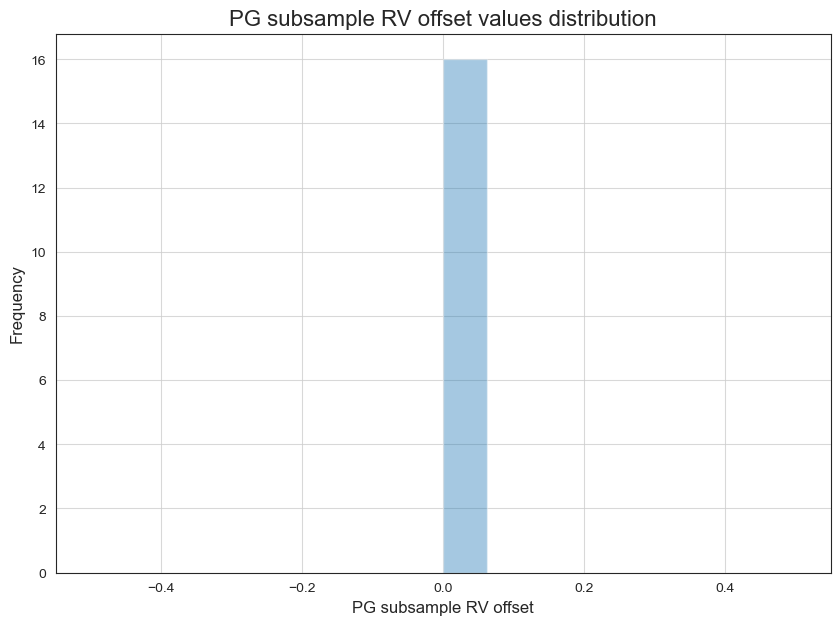

In [32]:
draw_hist(d1=rv_offsets, d1_label="PG subsample RV offset")

We try to fit the distribution with `distfit`.

In [33]:
min(rv_offsets)

0

In [34]:
max(rv_offsets)

0

**Notice:** as we see, there is no reason at all to do this fit, as we know beforehand that all offsets are $0$. We just keep the fit try in order to see how the `distfit` module works with strange values as these ones. Later on in this same section we will overwrite this distibution with a fixed value of $0$.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.0 sec] [RSS: nan] [loc=0.000 scale=0.000]
[distfit] >[expon     ] [0.00 sec] [RSS: nan] [loc=0.000 scale=0.000]
[distfit] >[pareto    ] [0.00 sec] [RSS: nan] [loc=-0.000 scale=0.000]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 2258.2422485] [loc=0.000 scale=1.161]
[distfit] >[t         ] [0.09 sec] [RSS: 2500.0000000] [loc=-0.000 scale=0.000]
[distfit] >[genextreme] [0.12 sec] [RSS: 2500.0000000] [loc=-0.000 scale=0.000]
[distfit] >[lognorm   ] [0.07 sec] [RSS: 2500.0000000] [loc=-0.000 scale=0.000]
[distfit] >[beta      ] [0.06 sec] [RSS: 2500.0000000] [loc=-0.000 scale=0.000]
[distfit] >[uniform   ] [0.0 sec] [RSS: nan] [loc=0.000 scale=0.000]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 2500.0000000] [loc=-0.000 scale=0.000]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


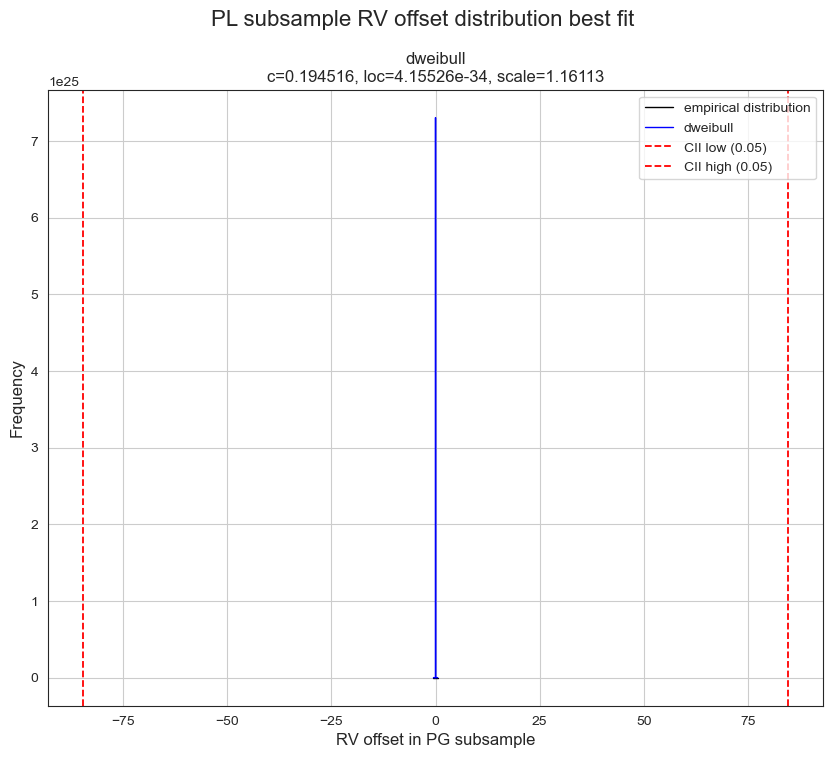

In [35]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_offsets))
# Plot results:
dist.plot()
plt.suptitle("PL subsample RV offset distribution best fit", fontsize=16)
plt.xlabel("RV offset in PG subsample", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [36]:
# Generate a new sample:
repro_offsets = dist.generate(n=len(rv_offsets), random_state=RANDOM_STATE)

[distfit] >Generate 269 dweibull distributed samples with fitted params (0.19451622991431783, 4.155260197271249e-34, 1.161132255170155).


In [37]:
dist.model['name']

'dweibull'

stat=-0.241, p=0.810
Probably the same distribution


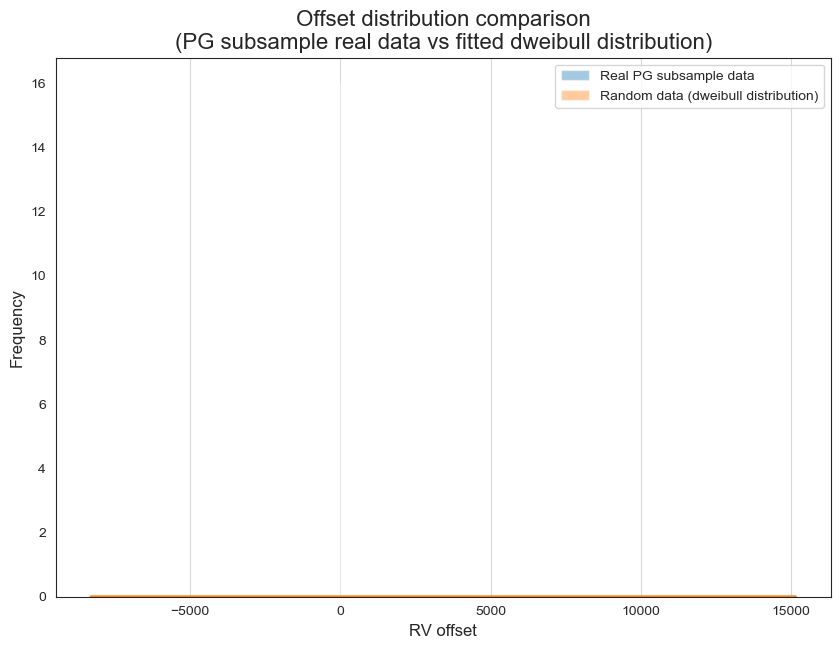

In [38]:
# Compare real and random sample:
compare_dist(rv_offsets, repro_offsets,"Real PG subsample data", "Random data (%s distribution)" %dist.model['name'],
             fig_title="Offset distribution comparison\n(PG subsample real data vs fitted %s distribution)" %dist.model['name'],
             varname="RV offset",
             fig_filename=IMAGE_FOLDER + "SD_09_01_PG_subsample_RV_Offset_distfit.png")


As we see, trying to fit a distribution to a value that we know is a fixed 0 value yields weird results.

Hence, we just set this "distribution" to a fixed value of 0.0.

In [39]:
group = "BENCHMARK"
variable = "offsetRV"
d_model = dict({'fixed_value': 0.0}) # Special mode meaning "fixed value" (no distribution file is saved)
dist_to_save = None
filename = None
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

In [40]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},None
1,BENCHMARK,Tobs,{'fixed_value': 4.2},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_PG_subsample_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_PG_subsample_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_PG_subsample_dist.pickle
5,BENCHMARK,offsetRV,{'fixed_value': 0.0},None


#### CARMENES PG subsample reference epoch (from real data)

Having gathered all the reference epoch values before, we will go for the best fit distribution for all the data.

count    2.690000e+02
mean     2.457731e+06
std      5.616325e+02
min      2.457395e+06
25%      2.457416e+06
50%      2.457490e+06
75%      2.457674e+06
max      2.459491e+06
dtype: float64
p = 2.21223e-23
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


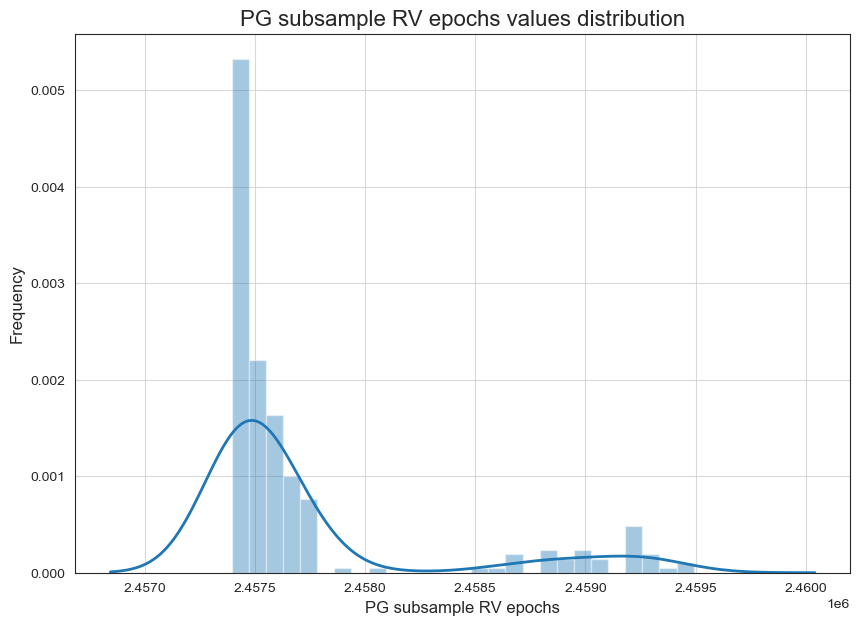

In [41]:
draw_hist(d1=rv_epochs, d1_label="PG subsample RV epochs")

We try to fit the distribution with `distfit`.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000693] [loc=2457730.704 scale=560.588]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0000318] [loc=2457395.247 scale=335.457]
[distfit] >[pareto    ] [0.00 sec] [RSS: 0.0000035] [loc=2457348.079 scale=47.168]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 0.0000487] [loc=2457397.681 scale=433.069]
[distfit] >[t         ] [0.08 sec] [RSS: 0.0000866] [loc=-5816.195 scale=2460683.537]
[distfit] >[genextreme] [0.15 sec] [RSS: 0.0000070] [loc=2457413.379 scale=44.763]
[distfit] >[gamma     ] [0.04 sec] [RSS: 0.0000086] [loc=2457395.247 scale=517.975]
[distfit] >[lognorm   ] [0.04 sec] [RSS: 0.0000063] [loc=2457395.239 scale=52.632]
[distfit] >[beta      ] [0.06 sec] [RSS: 0.0000526] [loc=2457395.247 scale=2515.004]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0000752] [loc=2457395.247 scale=2095.433]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 0.0000698] [loc=2256760.716 scale=26258.124]
[distfit] >Compute confidence inter

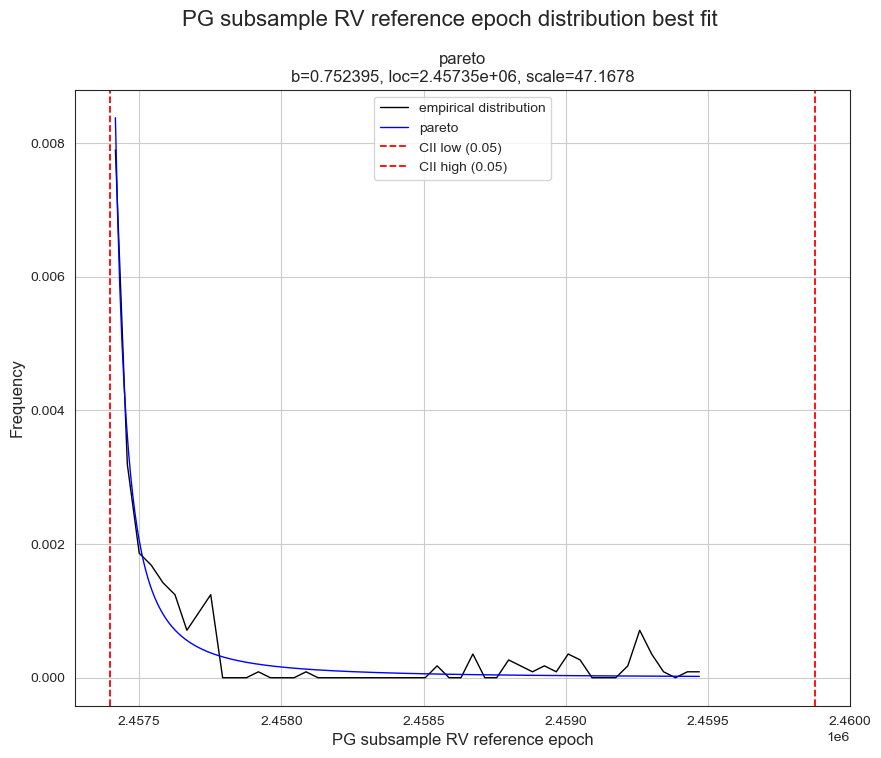

In [42]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_epochs))
# Plot results:
dist.plot()
plt.suptitle("PG subsample RV reference epoch distribution best fit", fontsize=16)
plt.xlabel("PG subsample RV reference epoch", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [43]:
# Generate a new sample:
repro_epochs = dist.generate(n=len(rv_epochs), random_state=RANDOM_STATE)

[distfit] >Generate 269 pareto distributed samples with fitted params (0.7523946904028169, 2457348.0793041247, 47.167760103475295).


stat=-1.552, p=0.121
Probably the same distribution


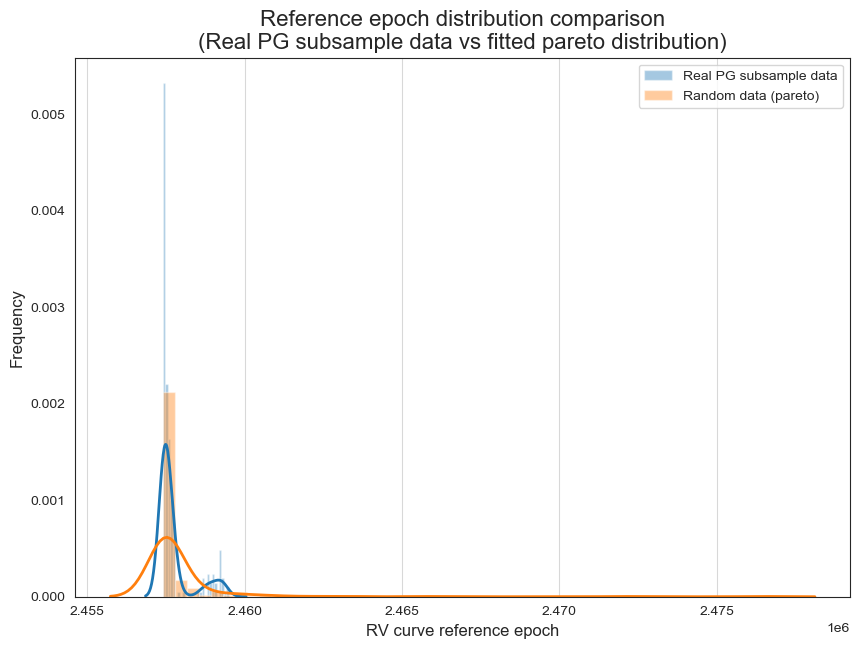

In [44]:
# Compare real and random sample:
compare_dist(rv_epochs, repro_epochs,
             "Real PG subsample data", "Random data (%s)" %dist.model['name'],
             fig_title="Reference epoch distribution comparison\n(Real PG subsample data vs fitted %s distribution)" %dist.model['name'],
             varname="RV curve reference epoch",
             fig_filename=IMAGE_FOLDER + "SD_09_02_PG_subsample_RV_RefEpoch_distfit.png")


**OBSERVATION:** although both distributions (fitted and real) do not seem similar, the ranges of values are similar in those cases, and that's enough for our purposes, as reference epoch is just an arbitrary time reference in our case.

In [45]:
dist.model

{'distr': <scipy.stats._continuous_distns.pareto_gen at 0x20cff472340>,
 'stats': 'RSS',
 'params': (0.7523946904028169, 2457348.0793041247, 47.167760103475295),
 'name': 'pareto',
 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x20c845bcf10>,
 'score': 3.5031996659083197e-06,
 'loc': 2457348.0793041247,
 'scale': 47.167760103475295,
 'arg': (0.7523946904028169,),
 'CII_min_alpha': 2457398.574792719,
 'CII_max_alpha': 2459876.391863223}

In [46]:
group = "BENCHMARK"
variable = "refepochRV"
d_model = dist.model
filename = group + "_" + variable +"_PG_subsample_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[pypickle] Pickle file saved: [../data/DIST_FILES/BENCHMARK_refepochRV_PG_subsample_dist.pickle]
[distfit] >Saving.. True


In [47]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},None
1,BENCHMARK,Tobs,{'fixed_value': 4.2},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_PG_subsample_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_PG_subsample_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_PG_subsample_dist.pickle
5,BENCHMARK,offsetRV,{'fixed_value': 0.0},None
6,BENCHMARK,refepochRV,{'distr': <scipy.stats._continuous_distns.pare...,BENCHMARK_refepochRV_PG_subsample_dist.pickle


#### CARMENES PG subsample noise (from real data)

**NOTE:** although we use a new approach for incorporating noise into the synthetic datasets (i.e. fit individual noise distributions to each of the real samples, then randomly chose one of those distributions to generate the noise for each object in the synthetic sample - in synch with the randomly chosen sampling pattern), we still try to record a single overall distribution for all the noise values present in all the data points of all the time series present in the PG subsample. Just to keep it as a reference.

count    13463.000000
mean         8.535036
std         89.982237
min          0.709165
25%          1.339658
50%          1.684392
75%          2.429571
max       3173.254626
dtype: float64
p = 0
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


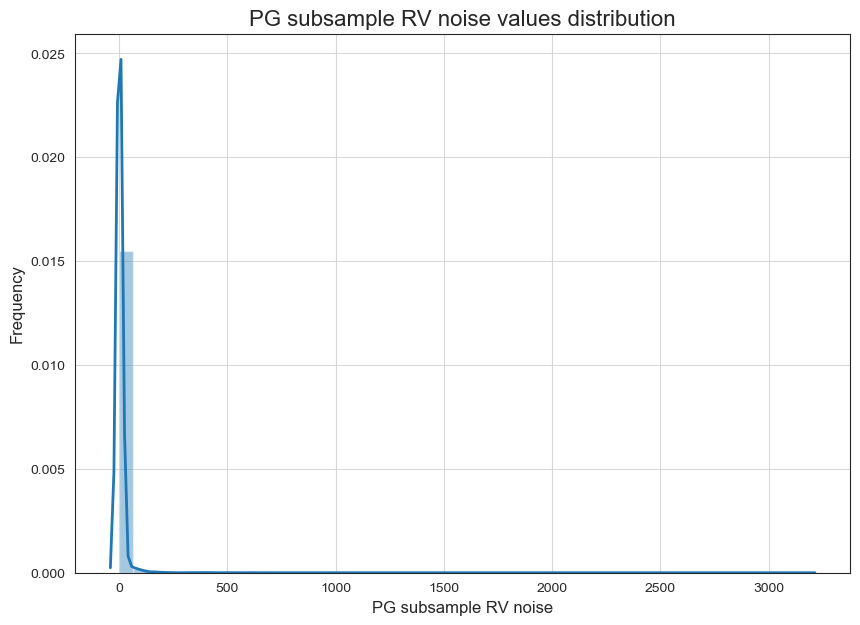

In [48]:
draw_hist(d1=rv_errors, d1_label="PG subsample RV noise")

We try to fit the distribution with `distfit`.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0001339] [loc=8.535 scale=89.979]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0001766] [loc=0.709 scale=7.826]
[distfit] >[pareto    ] [0.00 sec] [RSS: 0.0002273] [loc=-1.427 scale=2.136]
[distfit] >[dweibull  ] [0.23 sec] [RSS: 0.0002303] [loc=1.451 scale=1.120]
[distfit] >[t         ] [0.22 sec] [RSS: 0.0002340] [loc=1.542 scale=0.347]
[distfit] >[genextreme] [0.18 sec] [RSS: 0.0002188] [loc=1.553 scale=0.812]
[distfit] >[gamma     ] [0.15 sec] [RSS: 0.0002404] [loc=0.709 scale=4.926]
[distfit] >[lognorm   ] [0.13 sec] [RSS: 0.0002353] [loc=0.709 scale=1.221]
[distfit] >[beta      ] [0.29 sec] [RSS: 0.0002299] [loc=0.709 scale=7049.036]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0002354] [loc=0.709 scale=3172.545]
[distfit] >[loggamma  ] [0.11 sec] [RSS: 0.0001517] [loc=-46916.579 scale=5898.624]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


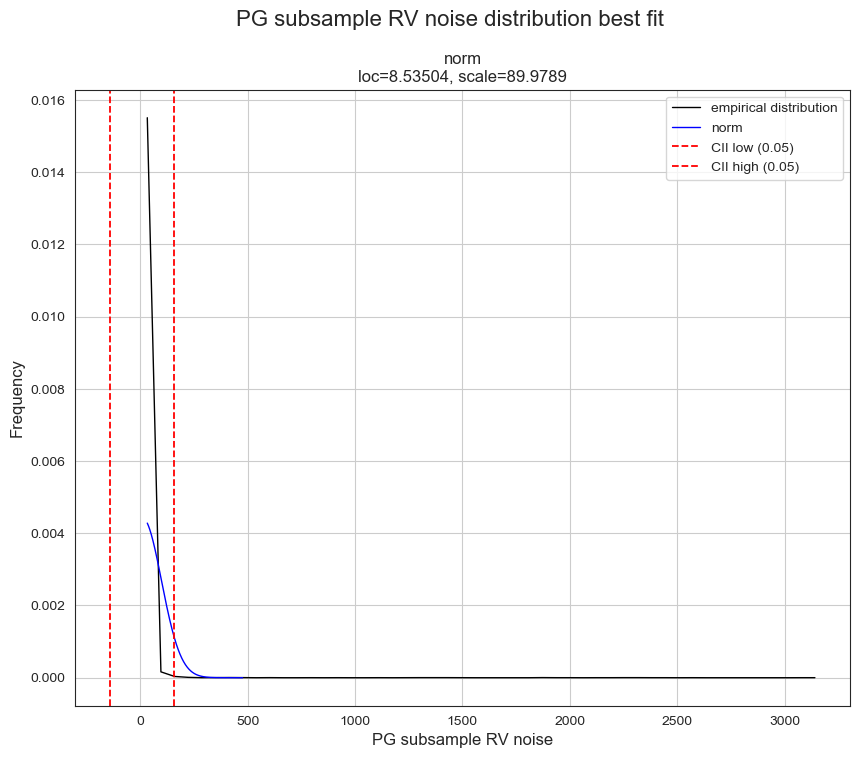

In [49]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_errors))
# Plot results:
dist.plot()
plt.suptitle("PG subsample RV noise distribution best fit", fontsize=16)
plt.xlabel("PG subsample RV noise", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [50]:
# Generate a new sample:
repro_rms = dist.generate(n=len(rv_errors), random_state=RANDOM_STATE)

[distfit] >Generate 13463 norm distributed samples with fitted params (8.535036123951066, 89.97889485615188).


stat=-0.130, p=0.897
Probably the same distribution


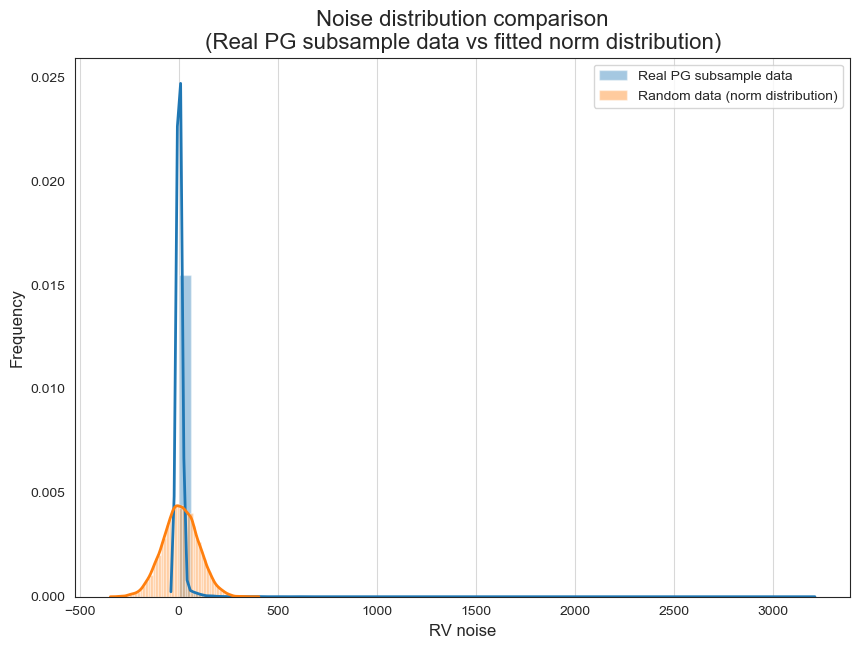

In [51]:
# Compare real and random sample:
compare_dist(rv_errors, repro_rms,
             "Real PG subsample data", "Random data (%s distribution)" %dist.model['name'],
             fig_title="Noise distribution comparison\n(Real PG subsample data vs fitted %s distribution)" %dist.model['name'],
             varname="RV noise",
             fig_filename=IMAGE_FOLDER + "SD_09_03_PG_subsample_RV_Noise_INITIAL_distfit.png")


**OBSERVATION:** visually, the two distributions (fitted and real) do not seem similar to each other, but the statistical test says they can come from the same distribution, so we move forward with it.

In [52]:
group = "RV"
variable = "noiseRV"
d_model = dist.model
filename = group + "_" + variable +"_PG_subsample_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[pypickle] Pickle file saved: [../data/DIST_FILES/RV_noiseRV_PG_subsample_dist.pickle]
[distfit] >Saving.. True


In [53]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},None
1,BENCHMARK,Tobs,{'fixed_value': 4.2},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_PG_subsample_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_PG_subsample_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_PG_subsample_dist.pickle
5,BENCHMARK,offsetRV,{'fixed_value': 0.0},None
6,BENCHMARK,refepochRV,{'distr': <scipy.stats._continuous_distns.pare...,BENCHMARK_refepochRV_PG_subsample_dist.pickle
7,RV,noiseRV,{'distr': <scipy.stats._continuous_distns.norm...,RV_noiseRV_PG_subsample_dist.pickle


**IMPORTANT FOR THE NEW APPROACH**: Let's now record the best distributions for the errors of each of the curve. Individualization of error distribution to each of the curves makes sense because of the possible instrument degradation or improvement throughout the CARMENES survey and the differences in the errors for the different objects observed (specially, their different brightness).

**NOTE:** with the new approach, we will be doing this also when we establish the sampling pattern for each of the PG subsample curve in a later notebook.

In [54]:
# Initialize:
gto['bestdist_name_RV'] = ""
gto['bestdist_loc_RV'] = None
gto['bestdist_scale_RV'] = None
gto['bestdist_score_RV'] = None
gto['bestdist_error_RV'] = ""
#for i in range(0, 10):
for i in range(0, len(gto)):
    rv_file = gto.loc[i, 'rv_file']
    rv = pd.read_csv(rv_file, sep=' ', decimal='.',
                     names=['time', 'rv', 'rv_error'])
    try:
        dist = distfit()
        # Fit the data:
        dist.fit_transform(rv['rv_error'], verbose=2)
        #print(dist.model)
        gto.loc[i, 'bestdist_name_RV'] = dist.model['name']
        gto.loc[i, 'bestdist_loc_RV'] = dist.model['loc']
        gto.loc[i, 'bestdist_scale_RV'] = dist.model['scale']
        gto.loc[i, 'bestdist_score_RV'] = dist.model['score']
        
    except Exception as e:
        print("Error found at record %d: %s" %(i, str(e)))
        gto.loc[i, 'bestdist_error_RV'] = str(e)
gto.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,WF_elapsed_time_PG_TESS,WF_plain_file_TESS,WF_fig_file_TESS,PG_file_RV,PG_file_TESS,bestdist_name_RV,bestdist_loc_RV,bestdist_scale_RV,bestdist_score_RV,bestdist_error_RV
0,J23548+385,RX J2354.8+3831,-,NaN,358.713658,38.526340,23:54:51.46,+38:31:36.2,110.941908,-23.024449,...,94.758838,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23548+38...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23548+385_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23548+385_RV_PG.dat,beta,2.051089,3.210288,26.933587,
1,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,-67.303426,...,132.607176,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23505-09...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23505-095_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23505-095_RV_PG.dat,t,1.691561,0.290193,2.32868,
2,J23431+365,GJ 1289,-,1289,355.781509,36.536310,23:43:06.31,+36:32:13.1,107.922839,-24.336479,...,97.939914,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23431+36...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23431+365_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23431+365_RV_PG.dat,dweibull,1.403768,0.233191,125.615873,
3,J23381-162,G 273-093,-,4352,354.532687,-16.236514,23:38:08.16,-16:14:10.2,61.845437,-69.825220,...,136.603404,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23381-16...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23381-162_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23381-162_RV_PG.dat,genextreme,1.343269,0.248643,6.268365,
4,J23245+578,BD+57 2735,-,895,351.126628,57.853057,23:24:30.51,+57:51:15.5,111.552287,-3.085183,...,131.327304,../data/CARM_VIS_TESS_WinFunc_PGs/WF_J23245+57...,../data/CARM_VIS_TESS_WinFunc_PGs/figures/WF_J...,../data/CARM_VIS_RVs_PGs/J23245+578_RV_PG.dat,../data/CARM_VIS_TESS_PGs/J23245+578_RV_PG.dat,lognorm,1.039512,0.554111,12.425912,


We can now check the individual distributions:

In [55]:
gto[['bestdist_name_RV', 'Karmn']].groupby(by='bestdist_name_RV').count()

,Karmn
bestdist_name_RV,
beta,39
dweibull,52
expon,6
gamma,14
genextreme,77
loggamma,1
lognorm,36
pareto,12
t,31


As we can see, when computed individually, the distributions are pretty different from each other. Let's see the `loc` and `scale` parameters distribution:

count    2.690000e+02
mean    -6.236523e+04
std      1.022925e+06
min     -1.677722e+07
25%      1.178147e+00
50%      1.418879e+00
75%      2.030162e+00
max      1.206570e+02
Name: bestdist_loc_RV, dtype: float64
p = 6.22506e-134
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


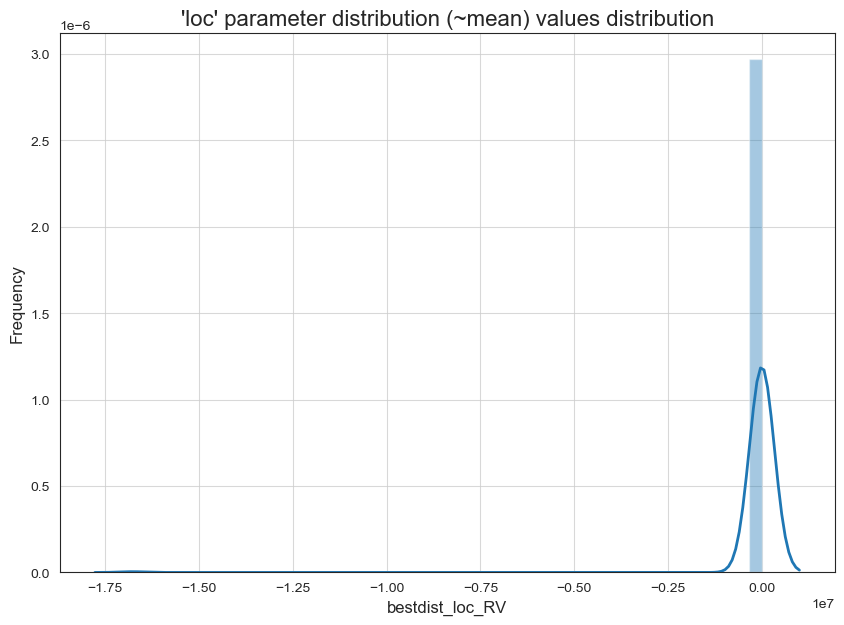

In [56]:
draw_hist(d1=gto['bestdist_loc_RV'].astype(float), d1_label="'loc' parameter distribution (~mean)")

count    2.690000e+02
mean     1.167511e+11
std      1.816204e+12
min      2.488193e-04
25%      2.661670e-01
50%      4.578411e-01
75%      1.629273e+00
max      2.975254e+13
Name: bestdist_scale_RV, dtype: float64
p = 1.09993e-133
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


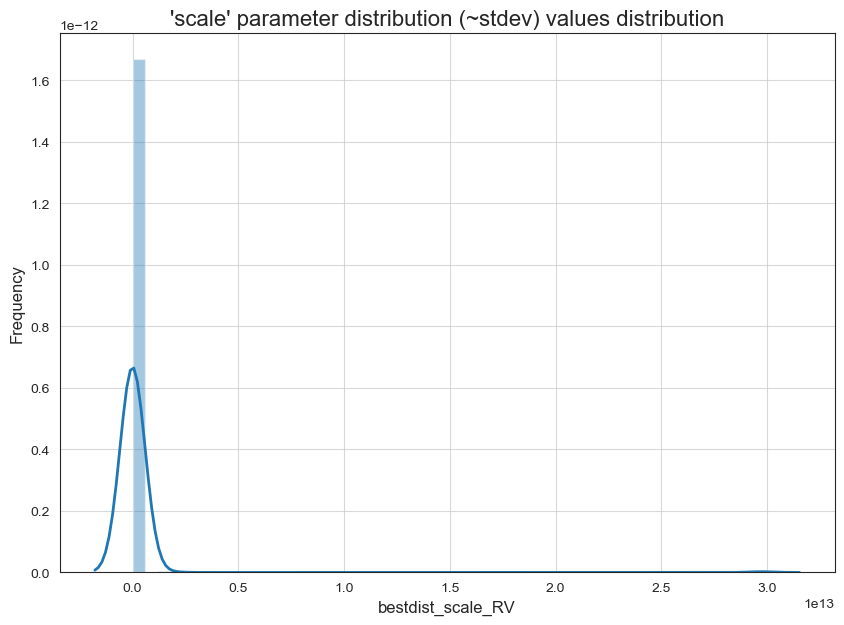

In [58]:
draw_hist(d1=gto['bestdist_scale_RV'].astype(float), d1_label="'scale' parameter distribution (~stdev)")

**CONCLUSION:** It seems that noise distributions can be very different among the different time series. Hence, we will model the noise for each curve chosing one of these distributions, so as to have a pool to choose from for synthetic series generation.

That is to say, for each object in the synthetic sample, we will randomly chose a real object in the PG subsample, which will provide both the sampling pattern (number of samples and sampling spacing) and the distribution of the noise to generate the synthetic sample.

#### Sampling spacing for radial velocity curves (based on CARMENES PG subsample real data)

**NOTE:** once again, this is really not needed, as the exact sampling patterns of the real objects will be put in a pool from which the sampling patterns for each synthetic object will be randomly chosen.

count    269.000000
mean      16.728466
std       32.342565
min        0.003176
25%        3.045991
50%        8.935142
75%       18.022019
max      307.604864
Name: Ps_RV, dtype: float64
p = 2.39851e-77
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


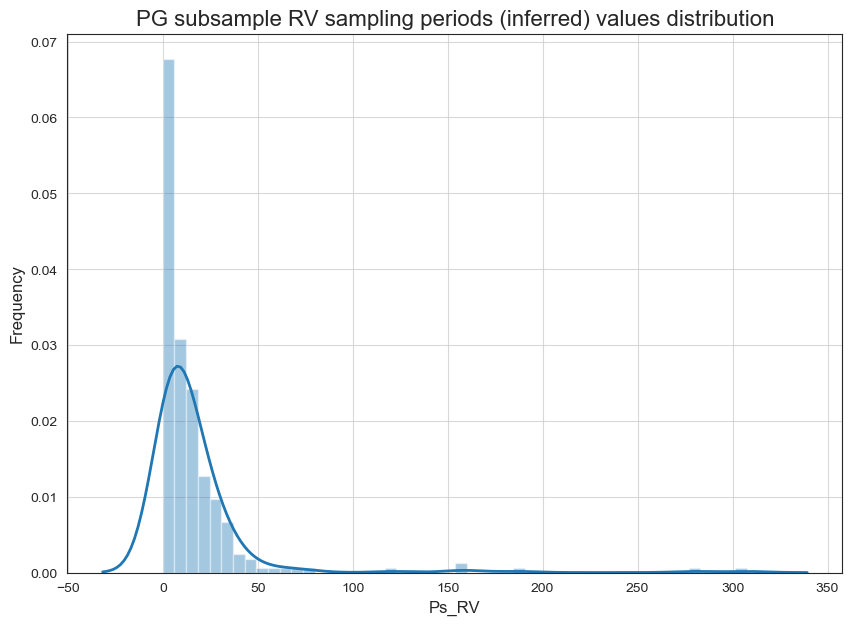

In [59]:
draw_hist(d1=gto['Ps_RV'], d1_label="PG subsample RV sampling periods (inferred)")

**Note:** units for x axis in the above figure are $d$.

In [60]:
gto['Ps_RV'].describe()

count    269.000000
mean      16.728466
std       32.342565
min        0.003176
25%        3.045991
50%        8.935142
75%       18.022019
max      307.604864
Name: Ps_RV, dtype: float64

In [61]:
gto['Ps_RV']. mean()

16.72846597621605

In [62]:
gto['Ps_RV']. median()

8.935142372734845

**OBSERVATION:** There seems to be great differences between the inferred sampling periods for the different RV curves, so we probably need to fit a distribution to simulate this.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0038707] [loc=16.728 scale=32.282]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0003764] [loc=0.003 scale=16.725]
[distfit] >[pareto    ] [0.00 sec] [RSS: 0.0000550] [loc=-32.408 scale=32.411]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 0.0008610] [loc=4.988 scale=9.226]
[distfit] >[t         ] [0.05 sec] [RSS: 0.0014976] [loc=8.051 scale=6.712]
[distfit] >[genextreme] [0.09 sec] [RSS: 0.0003352] [loc=5.317 scale=5.586]
[distfit] >[gamma     ] [0.04 sec] [RSS: 0.0056678] [loc=0.003 scale=3.537]
[distfit] >[lognorm   ] [0.03 sec] [RSS: 0.0001384] [loc=-0.216 scale=8.349]
[distfit] >[beta      ] [0.06 sec] [RSS: 0.0002657] [loc=0.003 scale=2913.920]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0058984] [loc=0.003 scale=307.602]
[distfit] >[loggamma  ] [0.03 sec] [RSS: 0.0040281] [loc=-14043.950 scale=1790.355]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


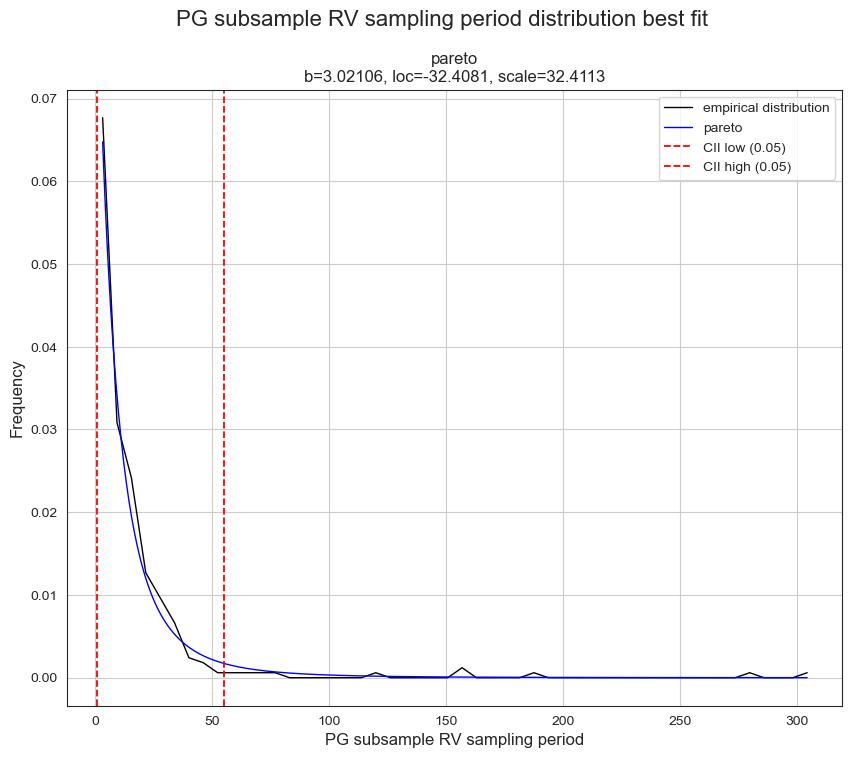

In [63]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(gto['Ps_RV'])
# Plot results:
dist.plot()
plt.suptitle("PG subsample RV sampling period distribution best fit", fontsize=16)
plt.xlabel("PG subsample RV sampling period", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [64]:
# Generate a new sample:
repro_ps = dist.generate(n=len(gto['Ps_RV']), random_state=RANDOM_STATE)

[distfit] >Generate 269 pareto distributed samples with fitted params (3.021059242698765, -32.4080868663928, 32.411262402097734).


stat=0.723, p=0.470
Probably the same distribution


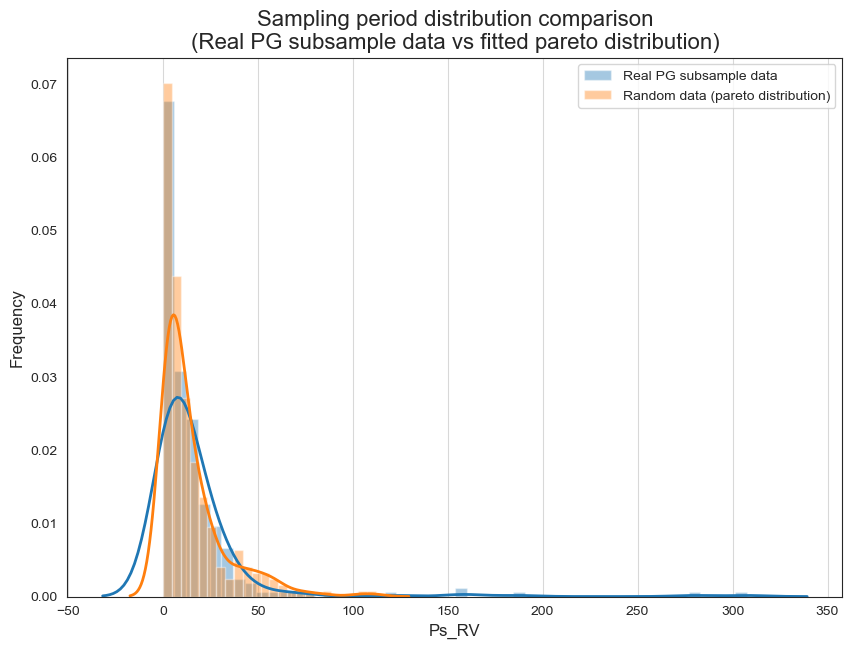

In [65]:
# Compare real and random sample:
compare_dist(gto['Ps_RV'], repro_ps,
             "Real PG subsample data", "Random data (%s distribution)" %dist.model['name'],
             fig_title="Sampling period distribution comparison\n(Real PG subsample data vs fitted %s distribution)" \
                 %dist.model['name'],
             varname="RV curve sampling period",
             fig_filename=IMAGE_FOLDER + "SD_09_04_PG_subsample_RV_SamplingPeriod_distfit.png")


**OBSERVATION:** this lognorm distribution approximation seems fine.

In [66]:
group = "RV"
variable = "samplingperiodRV"
d_model = dist.model
filename = group + "_" + variable +"_PG_subsample_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[pypickle] Pickle file saved: [../data/DIST_FILES/RV_samplingperiodRV_PG_subsample_dist.pickle]
[distfit] >Saving.. True


In [67]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},None
1,BENCHMARK,Tobs,{'fixed_value': 4.2},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_PG_subsample_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_PG_subsample_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_PG_subsample_dist.pickle
5,BENCHMARK,offsetRV,{'fixed_value': 0.0},None
6,BENCHMARK,refepochRV,{'distr': <scipy.stats._continuous_distns.pare...,BENCHMARK_refepochRV_PG_subsample_dist.pickle
7,RV,noiseRV,{'distr': <scipy.stats._continuous_distns.norm...,RV_noiseRV_PG_subsample_dist.pickle
8,RV,samplingperiodRV,{'distr': <scipy.stats._continuous_distns.pare...,RV_samplingperiodRV_PG_subsample_dist.pickle


#### Number of points for radial velocity curves (based on CARMENES PG subsample real data)

**NOTE:** once again, this is really not needed, as the exact sampling patterns of the real objects will be put in a pool from which the sampling patterns for each synthetic object will be randomly chosen.

count    269.000000
mean      50.048327
std       71.123667
min        4.000000
25%       14.000000
50%       30.000000
75%       58.000000
max      768.000000
Name: n_RV, dtype: float64
p = 3.77515e-74
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


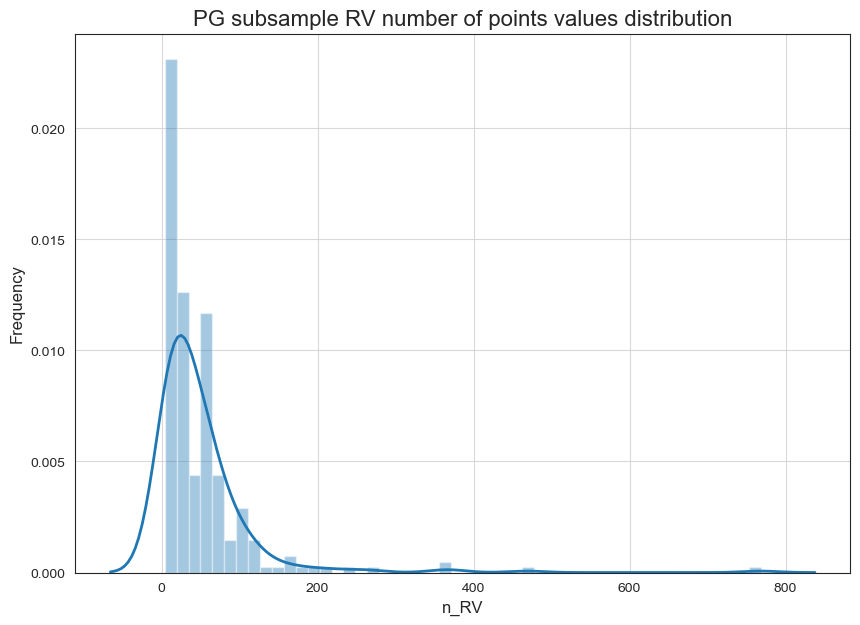

In [68]:
draw_hist(d1=gto['n_RV'], d1_label="PG subsample RV number of points")

In [69]:
gto['n_RV'].describe()

count    269.000000
mean      50.048327
std       71.123667
min        4.000000
25%       14.000000
50%       30.000000
75%       58.000000
max      768.000000
Name: n_RV, dtype: float64

In [70]:
gto['n_RV']. mean()

50.048327137546465

In [71]:
gto['n_RV']. median()

30.0

**OBSERVATION:** Again, there seems to be great differences in the number of samples taken from each PG subsample object, so a distribution will be used to generate the synthetic datasets.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0004562] [loc=50.048 scale=70.991]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0000791] [loc=4.000 scale=46.048]
[distfit] >[pareto    ] [0.00 sec] [RSS: 0.0000597] [loc=-134.523 scale=138.523]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 0.0002799] [loc=24.000 scale=34.649]
[distfit] >[t         ] [0.07 sec] [RSS: 0.0002807] [loc=30.826 scale=23.197]
[distfit] >[genextreme] [0.08 sec] [RSS: 0.0000820] [loc=20.526 scale=17.716]
[distfit] >[gamma     ] [0.05 sec] [RSS: 0.0006479] [loc=4.000 scale=22.194]
[distfit] >[lognorm   ] [0.02 sec] [RSS: 0.0000704] [loc=2.484 scale=26.096]
[distfit] >[beta      ] [0.06 sec] [RSS: 0.0000822] [loc=4.000 scale=5655.879]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0007974] [loc=4.000 scale=764.000]
[distfit] >[loggamma  ] [0.03 sec] [RSS: 0.0004749] [loc=-32315.216 scale=4071.371]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


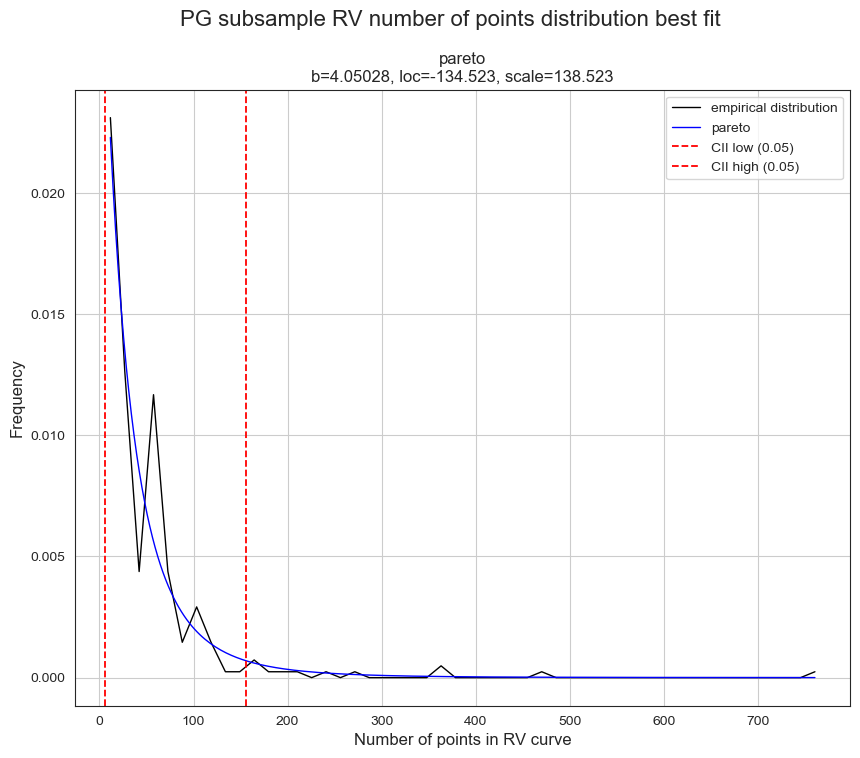

In [72]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(gto['n_RV'])
# Plot results:
dist.plot()
plt.suptitle("PG subsample RV number of points distribution best fit", fontsize=16)
plt.xlabel("Number of points in RV curve", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [73]:
# Generate a new sample:
repro_n = dist.generate(n=len(gto['n_RV']), random_state=RANDOM_STATE)

[distfit] >Generate 269 pareto distributed samples with fitted params (4.050279949422515, -134.52327467816446, 138.52327467816443).


stat=0.438, p=0.662
Probably the same distribution


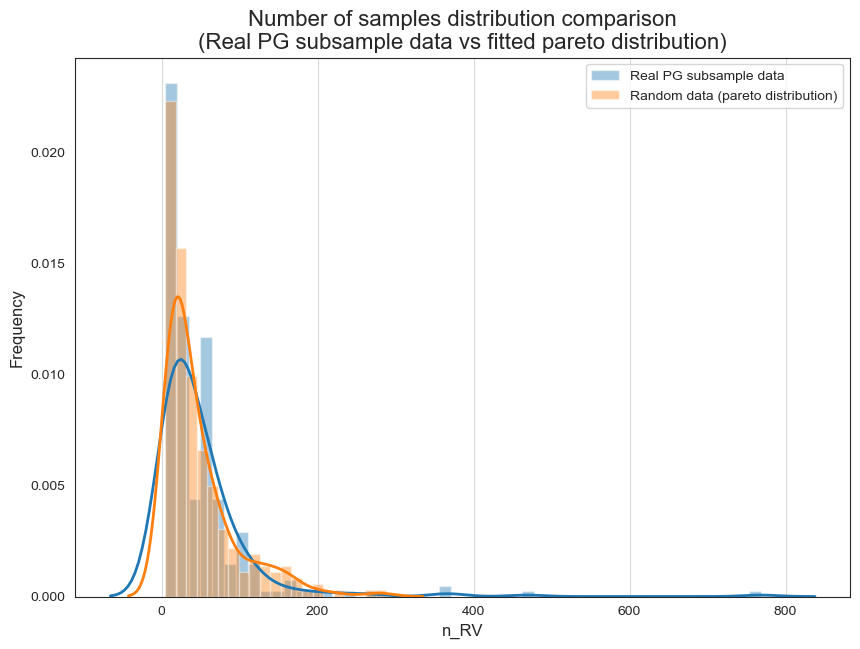

In [74]:
# Compare real and random sample:
compare_dist(gto['n_RV'], repro_n,
             "Real PG subsample data", "Random data (%s distribution)" %dist.model['name'],
             fig_title="Number of samples distribution comparison\n(Real PG subsample data vs fitted %s distribution)" \
                 %dist.model['name'],
             varname="Number points in RV curve",
             fig_filename=IMAGE_FOLDER + "SD_09_05_PG_subsample_RV_NumSamples_distfit.png")


**OBSERVATION:** this lognorm distribution approximation seems fine.

In [75]:
group = "RV"
variable = "numpointsRV"
d_model = dist.model
filename = group + "_" + variable +"_PG_subsample_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[pypickle] Pickle file saved: [../data/DIST_FILES/RV_numpointsRV_PG_subsample_dist.pickle]
[distfit] >Saving.. True


In [76]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},None
1,BENCHMARK,Tobs,{'fixed_value': 4.2},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_PG_subsample_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_PG_subsample_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_PG_subsample_dist.pickle
5,BENCHMARK,offsetRV,{'fixed_value': 0.0},None
6,BENCHMARK,refepochRV,{'distr': <scipy.stats._continuous_distns.pare...,BENCHMARK_refepochRV_PG_subsample_dist.pickle
7,RV,noiseRV,{'distr': <scipy.stats._continuous_distns.norm...,RV_noiseRV_PG_subsample_dist.pickle
8,RV,samplingperiodRV,{'distr': <scipy.stats._continuous_distns.pare...,RV_samplingperiodRV_PG_subsample_dist.pickle
9,RV,numpointsRV,{'distr': <scipy.stats._continuous_distns.pare...,RV_numpointsRV_PG_subsample_dist.pickle


**IMPORTANT NOTE ON CARMENES PG SUBSAMPLE RV SAMPLING:**

Although we have fitted distributions for the noise (throughout the full sample), the sampling spacing and the number of points, the approach will be another one: randomly assign real CARMENES RV curves sampling patterns and noise distribution from a pool composed of all the real PG subsample objects.

Anyway, we will kept those distributions in the table (and their _pickle_ file) in case they are used in the future.

## Summary

**OBSERVATIONS AND CONCLUSIONS:**
- We have completed the parameter analysis of all CARMENES PG subsample RV curves (but for 8 curves that gave trouble with periodogram calculation):
  - Benchmark: sampling period, constant at $0.0016\;d$.
  - Benchmark: observation period, constant at $4.2\;d$.
  - Benchmark: signal frequency, uniform distribution, $f\:\in\:[8.0, 72.0]\;d^{-1}$.
  - Benchmark: phase, uniform distribution, $\delta\;\in\;[0.0, 1.0]$.
  - Benchmark (RV): RV amplitude, uniform distribution, $A_{RV}\:\in\;[0.1, 1.5]\;ms^{-1}$.
  - Benchmark (RV): RV offset, fixed value of $0$.
  - Benchmark (RV): RV reference epoch, log-normal distribution.
  - RV: RV noise, normal distribution (this will not be used).
  - RV: RV sampling period, log-normal distribution (this will not be used).
  - RV: RV number of samples, log-normal distribution (this will not be used).
- All these distributions an a summary have been stored in files, so that they can be later used to generate the synthetic datasets.